In [ ]:
import marimo as mo
from skimage import io
import numpy as np
from skimage import io, filters, morphology, exposure, feature
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import cv2

Below is a practical, robust “detect → fit lattice → reconstruct → subpixel refine” pipeline that works well for circular-dot grids on dark backgrounds, even with rotation/perspective-ish tilt and a few missing dots.

The core idea is:

Enhance dots (background removal + DoG/LoG bandpass)

Detect dot candidates (local maxima)

Subpixel centroid refinement (fast quadratic fit or Gaussian fit)

Fit the grid lattice (estimate 2 basis directions + spacings)

Assign each detection to a (row, col) and reconstruct missing

Optionally refine again at predicted grid locations for best accuracy

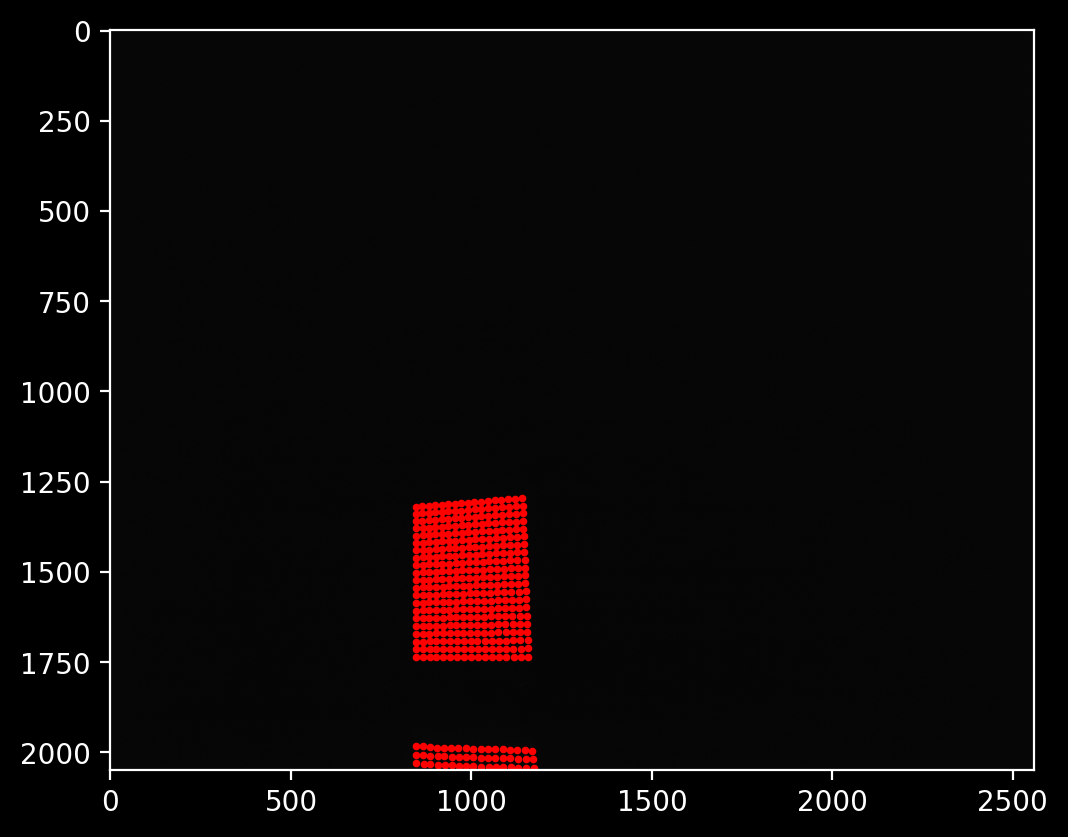

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# Load the image
# img = cv2.imread('input_file_0.jpeg')
if img.ndim == 2:
    gray = img.astype(np.uint8)
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# The image is very dark, let's look at the histogram or just try a threshold
# A simple threshold should work.
ret, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

# Find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)

# Filter by area to find the dots
# We expect 21 * 17 = 357 dots.
filtered_dots = []
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if 1 <= area <= 100:  # Adjust if necessary
        filtered_dots.append(centroids[i])
# return print(f"Number of dots detected: {len(filtered_dots)}")

filtered_dots = np.array(filtered_dots)
plt.figure()
plt.imshow(gray, cmap="gray")
plt.scatter(filtered_dots[:, 0], filtered_dots[:, 1], 3, "r")

Could not find exactly 357 dots. Found 408


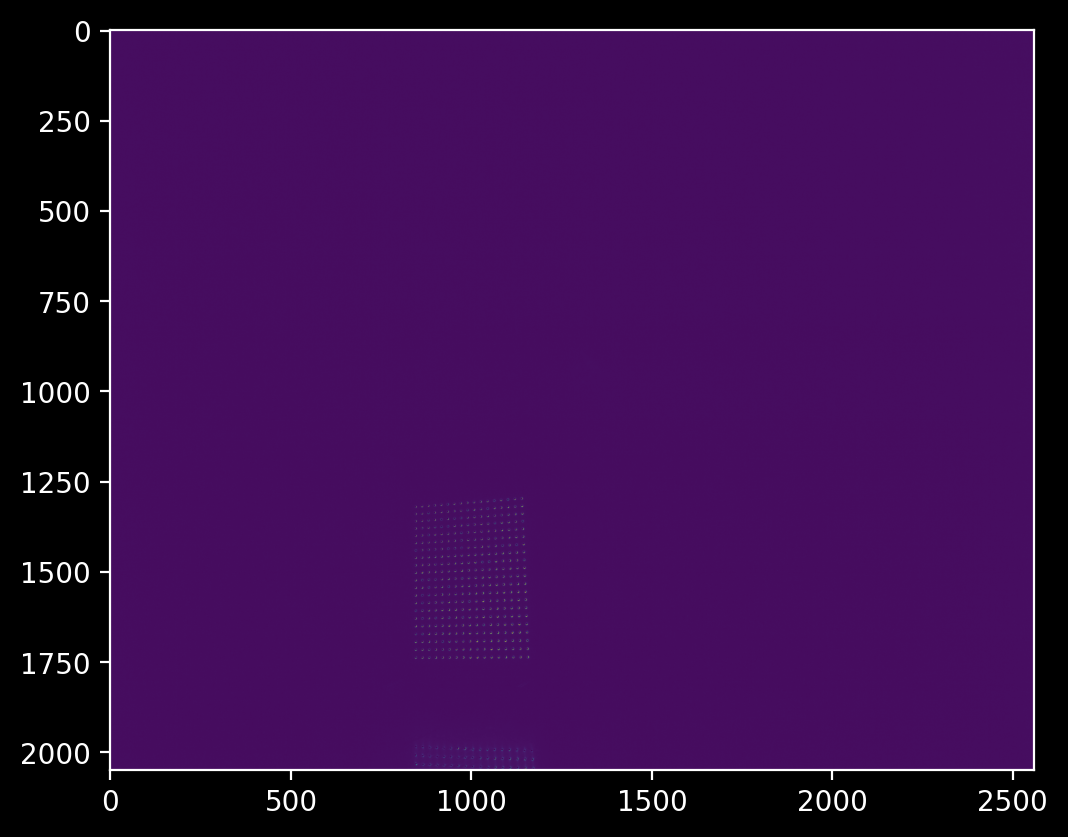

In [ ]:
# If we have the right number, let's sort them into a grid
if len(filtered_dots) == 357:
    # Sort by Y first
    dots = sorted(filtered_dots, key=lambda p: p[1])

    # Group into 21 rows
    grid = []
    for _i in range(21):
        row = dots[i * 17 : (_i + 1) * 17]
        # Sort each row by X
        row = sorted(row, key=lambda p: p[0])
        grid.append(row)

    print("Successfully organized into 21x17 grid.")
else:
    print("Could not find exactly 357 dots. Found", len(filtered_dots))
    # Let's try to visualize detections to debug
    debug_img = img.copy()
    for dot in filtered_dots:
        cv2.circle(debug_img, (int(dot[0]), int(dot[1])), 2, (0, 255, 0), -1)
    # cv2.imwrite('debug_detection.png', debug_img)

plt.figure()
plt.imshow(debug_img)
plt.gca()

In [ ]:
def ensure_2d_gray(img):
    """
    Convert possible (H,W,3/4) or (Z,H,W) into a single (H,W) float32 image.
    """
    img = np.asarray(img)

    # RGB / RGBA -> grayscale
    if img.ndim == 3 and img.shape[-1] in (3, 4):
        rgb = img[..., :3].astype(np.float32)
        # standard luminance; you can also just do rgb.mean(-1)
        img2 = (
            0.2126 * rgb[..., 0] + 0.7152 * rgb[..., 1] + 0.0722 * rgb[..., 2]
        )
        return img2.astype(np.float32)

    # Stack -> take max projection (often best for bright dots) or choose a slice
    if img.ndim == 3 and img.shape[0] not in (3, 4):
        # If it's (Z,H,W) use max projection; if it's (H,W,C) handled above
        return img.max(axis=0).astype(np.float32)

    # Already 2D
    if img.ndim == 2:
        return img.astype(np.float32)

    raise ValueError(f"Unsupported image shape: {img.shape}")

In [ ]:
def subpixel_peak_quadratic(patch3x3):
    c = patch3x3[1, 1]
    dxx = patch3x3[1, 2] - 2 * c + patch3x3[1, 0]
    dyy = patch3x3[2, 1] - 2 * c + patch3x3[0, 1]
    dx = 0.5 * (patch3x3[1, 2] - patch3x3[1, 0])
    dy = 0.5 * (patch3x3[2, 1] - patch3x3[0, 1])
    eps = 1e-12
    offx = 0.0 if abs(dxx) < eps else -dx / dxx
    offy = 0.0 if abs(dyy) < eps else -dy / dyy
    offx = float(np.clip(offx, -0.75, 0.75))
    offy = float(np.clip(offy, -0.75, 0.75))
    return offy, offx

In [ ]:
def keep_largest_cluster(points_yx, eps=0.9, min_samples=17 * 21):
    """
    Keep the largest DBSCAN cluster in (y,x) space.
    eps should be ~ 2–3x the dot spacing in pixels.
    """
    if len(points_yx) == 0:
        return points_yx

    pts = points_yx.astype(np.float32)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pts)
    labels = clustering.labels_

    # label -1 = noise
    good = labels >= 0
    if not np.any(good):
        return points_yx

    # largest cluster id
    uniq, counts = np.unique(labels[good], return_counts=True)
    best_label = uniq[np.argmax(counts)]
    return pts[labels == best_label]

In [ ]:
clustered_dots = keep_largest_cluster(filtered_dots, eps=.8,min_samples=357)
clustered_dots.shape

In [ ]:
# ---------- Lattice fit + forced 21x17 reconstruction ----------
def pca_rotate(points_yx) -> (np.ndarray, np.ndarray, np.ndarray):
    pts_xy = points_yx[:, ::-1].astype(np.float64)
    ctr = pts_xy.mean(axis=0)
    X = pts_xy - ctr
    C = np.cov(X.T)
    eigvals, eigvecs = np.linalg.eigh(C)
    V = eigvecs[:, np.argsort(eigvals)[::-1]]  # 2x2

    # V = eigvecs[:, np.argsort(eigvals)]
    U = X @ V  # rotated coords
    # If needed, enforce axis-0 to be the longer spread direction
    # (Often not necessary, but helpful when only part of grid is visible)
    if np.var(U[:, 0]) < np.var(U[:, 1]):
        V = V[:, ::-1]
        U = X @ V
    return U, V, ctr

In [ ]:
def estimate_spacing_1d(vals):
    v = np.sort(vals)
    d = np.diff(v)
    d = d[d > 1e-6]
    if len(d) == 0:
        return None
    med = np.median(d)
    d = d[d < 2.5 * med]  # reject large gaps
    return float(np.median(d)) if len(d) else float(med)

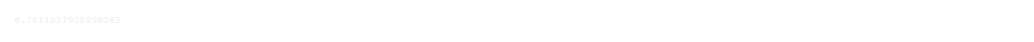

In [ ]:
estimate_spacing_1d(filtered_dots[:,1])

In [ ]:
def find_best_origin(U, dx, dy, nrows, ncols, nsteps=60):
    """
    Search u0,v0 offsets over [0,dx) and [0,dy) to maximize inliers.
    Returns (u0, v0).
    """
    u = U[:, 0]
    v = U[:, 1]

    # base anchors near the min corner
    u_min = np.percentile(u, 1)
    v_min = np.percentile(v, 1)

    best = None
    best_score = -1

    # scan fractional offsets
    for fu in np.linspace(0, dx, nsteps, endpoint=False):
        for fv in np.linspace(0, dy, nsteps, endpoint=False):
            u0 = u_min - fu
            v0 = v_min - fv

            col = np.rint((u - u0) / dx).astype(int)
            row = np.rint((v - v0) / dy).astype(int)

            ok = (row >= 0) & (row < nrows) & (col >= 0) & (col < ncols)
            score = int(ok.sum())

            if score > best_score:
                best_score = score
                best = (float(u0), float(v0))

    return best, best_score

In [ ]:
def force_grid_origin(U, dx, dy, nrows, ncols) -> (float, float):
    """
    Choose (u0,v0) so that (u-u0)/dx spans exactly ncols and (v-v0)/dy spans nrows.
    Using robust percentiles helps with missing points.
    """
    u, v = U[:, 0], U[:, 1]

    # Estimate extents of occupied grid (robust)
    u_lo, u_hi = np.percentile(u, 2), np.percentile(u, 98)
    v_lo, v_hi = np.percentile(v, 2), np.percentile(v, 98)

    # Back-calculate an origin that makes the span match (ncols-1)*dx etc.
    # If detection is partial, this still anchors reasonably.
    u0 = u_hi - (ncols - 1) * dx
    v0 = v_hi - (nrows - 1) * dy

    # If that seems off (e.g., u0 > u_lo), fallback to low percentile anchor
    if u0 > u_lo:
        u0 = u_lo
    if v0 > v_lo:
        v0 = v_lo

    return float(u0), float(v0)

In [ ]:
def assign_points_to_grid(U, dx, dy, u0, v0, nrows, ncols):
    u, v = U[:, 0], U[:, 1]
    col = np.round((u - u0) / dx).astype(int)
    row = np.round((v - v0) / dy).astype(int)

    # keep only in-range assignments
    ok = (row >= 0) & (row < nrows) & (col >= 0) & (col < ncols)
    return row, col, ok

In [ ]:
def assign_to_grid(U, dx, dy):
    """
    Given rotated points U[:,0]=u, U[:,1]=v and spacings dx,dy,
    assign integer col,row using rounded coordinates relative to a robust origin.
    """
    u = U[:, 0]
    v = U[:, 1]

    # robust origin: use low-percentile as approximate (top-left-ish) anchor
    u0 = np.percentile(u, 5)
    v0 = np.percentile(v, 5)

    col = np.round((u - u0) / dx).astype(int)
    row = np.round((v - v0) / dy).astype(int)

    # shift so minimum is 0
    col -= col.min()
    row -= row.min()
    return row, col, u0, v0

In [ ]:
# ---------- Final refinement at each grid location ----------


def refine_at_predictions(
    img, pred_yx, search_radius=5, bg_sigma=25, dog_sigma1=1.2, dog_sigma2=2.6
) -> np.ndarray:
    dog = preprocess_and_dog(img, bg_sigma, dog_sigma1, dog_sigma2)
    H, W = dog.shape
    refined = np.full(pred_yx.shape, np.nan, dtype=np.float32)

    for r in range(pred_yx.shape[0]):
        for c in range(pred_yx.shape[1]):
            y0, x0 = pred_yx[r, c]
            y0i, x0i = int(round(y0)), int(round(x0))
            y1, y2 = (
                max(1, y0i - search_radius),
                min(H - 2, y0i + search_radius),
            )
            x1, x2 = (
                max(1, x0i - search_radius),
                min(W - 2, x0i + search_radius),
            )
            if y2 <= y1 or x2 <= x1:
                continue

            win = dog[y1 : y2 + 1, x1 : x2 + 1]
            wy, wx = np.unravel_index(np.argmax(win), win.shape)
            yy, xx = y1 + wy, x1 + wx

            patch = dog[yy - 1 : yy + 2, xx - 1 : xx + 2]
            offy, offx = subpixel_peak_quadratic(patch)
            refined[r, c] = (yy + offy, xx + offx)

    return refined

In [ ]:
def preprocess_and_dog(img, bg_sigma=25, dog_sigma1=1.2, dog_sigma2=2.6):
    img = img.astype(np.float32)
    img = img - np.percentile(img, 1)
    img = np.clip(img, 0, None)

    bg = gaussian_filter(img, bg_sigma)
    hp = np.clip(img - bg, 0, None)

    g1 = gaussian_filter(hp, dog_sigma1)
    g2 = gaussian_filter(hp, dog_sigma2)
    dog = g1 - g2
    dog = exposure.rescale_intensity(dog, in_range="image", out_range=(0, 1))
    return dog

In [ ]:
def detect_dots_subpixel(
    img,
    min_distance=5,
    thresh_rel=0.2,
    bg_sigma=25,
    dog_sigma1=1.2,
    dog_sigma2=2.6,
) -> (np.ndarray, np.ndarray):
    dog = preprocess_and_dog(img, bg_sigma, dog_sigma1, dog_sigma2)
    coords = feature.peak_local_max(
        dog,
        min_distance=min_distance,
        threshold_abs=thresh_rel * float(dog.max()),
        exclude_border=False,
    )
    H, W = dog.shape
    pts = []
    for y, x in coords:
        if 1 <= y < H - 1 and 1 <= x < W - 1:
            patch = dog[y - 1 : y + 2, x - 1 : x + 2]
            offy, offx = subpixel_peak_quadratic(patch)
            pts.append((y + offy, x + offx))
        else:
            pts.append((float(y), float(x)))
    return np.array(pts, np.float32), dog

In [ ]:
def reconstruct_grid_robust(
    points_yx, expected_shape=(21, 17), origin_scan_steps=60
):
    nrows, ncols = expected_shape

    U, V, ctr = pca_rotate(points_yx)

    dx = estimate_spacing_1d(U[:, 0])
    dy = estimate_spacing_1d(U[:, 1])
    if dx is None or dy is None:
        raise RuntimeError(
            "Could not estimate grid spacing; too few detections."
        )

    (u0, v0), score = find_best_origin(
        U, dx, dy, nrows, ncols, nsteps=origin_scan_steps
    )

    row, col, ok = assign_points_to_grid(U, dx, dy, u0, v0, nrows, ncols)

    # predicted grid (u,v)
    uu = u0 + dx * np.arange(ncols)
    vv = v0 + dy * np.arange(nrows)
    UU, VV = np.meshgrid(uu, vv)
    pred_uv = np.stack([UU, VV], axis=-1)

    # back to image coords
    pred_xy = pred_uv @ V.T + ctr
    pred_yx = pred_xy[..., ::-1].astype(np.float32)

    # map detections to slots, resolve collisions by closest-to-pred
    grid_map = {}
    for i in np.where(ok)[0]:
        r, c = int(row[i]), int(col[i])
        if (r, c) not in grid_map:
            grid_map[(r, c)] = i
        else:
            prev = grid_map[(r, c)]
            pyx = pred_yx[r, c]
            d_new = np.sum((points_yx[i] - pyx) ** 2)
            d_old = np.sum((points_yx[prev] - pyx) ** 2)
            if d_new < d_old:
                grid_map[(r, c)] = i

    return grid_map, pred_yx, (dx, dy), score

In [ ]:
# ---------- Convenience wrapper ----------
def find_grid_centroids(
    img,
    nrows=21,
    ncols=17,
    min_distance=5,
    thresh_rel=0.2,
    bg_sigma=25,
    dog_sigma1=1.2,
    dog_sigma2=2.6,
    search_radius=5,
) -> (np.ndarray, dict, np.ndarray, np.ndarray):
    img = ensure_2d_gray(img)  # <-- ADD THIS LINE

    pts_yx, dog = detect_dots_subpixel(
        img,
        min_distance=min_distance,
        thresh_rel=thresh_rel,
        bg_sigma=bg_sigma,
        dog_sigma1=dog_sigma1,
        dog_sigma2=dog_sigma2,
    )

    grid_map, pred_yx, _, _, _ = reconstruct_grid(
        pts_yx, expected_shape=(nrows, ncols)
    )
    refined_yx = refine_at_predictions(
        img,
        pred_yx,
        search_radius=search_radius,
        bg_sigma=bg_sigma,
        dog_sigma1=dog_sigma1,
        dog_sigma2=dog_sigma2,
    )

    # final output: detected where available else refined else predicted
    final = pred_yx.copy()
    for r in range(nrows):
        for c in range(ncols):
            if (r, c) in grid_map:
                final[r, c] = pts_yx[grid_map[(r, c)]]
            elif not np.isnan(refined_yx[r, c, 0]):
                final[r, c] = refined_yx[r, c]
            # else keep pred_yx

    return final, grid_map, pts_yx, dog

In [ ]:
def find_grid_centroids_robust(
    img,
    nrows=21,
    ncols=17,
    min_distance=6,
    thresh_rel=0.18,
    bg_sigma=15,
    dog_sigma1=0.9,
    dog_sigma2=1.8,
    search_radius=4,
    cluster_eps=35,
    cluster_min_samples=10,
    origin_scan_steps=60,
):
    img = ensure_2d_gray(img)

    pts_yx, dog = detect_dots_subpixel(
        img,
        min_distance=min_distance,
        thresh_rel=thresh_rel,
        bg_sigma=bg_sigma,
        dog_sigma1=dog_sigma1,
        dog_sigma2=dog_sigma2,
    )

    # ✅ drop outliers (your screenshot shows you need this)
    pts_yx_f = keep_largest_cluster(
        pts_yx, eps=cluster_eps, min_samples=cluster_min_samples
    )

    grid_map, pred_yx, _, score = reconstruct_grid_robust(
        pts_yx_f,
        expected_shape=(nrows, ncols),
        origin_scan_steps=origin_scan_steps,
    )

    refined_yx = refine_at_predictions(
        img,
        pred_yx,
        search_radius=search_radius,
        bg_sigma=bg_sigma,
        dog_sigma1=dog_sigma1,
        dog_sigma2=dog_sigma2,
    )

    final = pred_yx.copy()
    for r in range(nrows):
        for c in range(ncols):
            if (r, c) in grid_map:
                final[r, c] = pts_yx_f[grid_map[(r, c)]]
            elif not np.isnan(refined_yx[r, c, 0]):
                final[r, c] = refined_yx[r, c]

    return final, grid_map, pts_yx_f, dog, score

In [ ]:
img = io.imread(
    # "/home/user/Dropbox/3DPTV_Illmenau/00000000_000000001895A641.png"
    "/home/user/Dropbox/3DPTV_Illmenau/00000093_0000000018B72D72.png"
)  # grayscale preferred

img = ensure_2d_gray(img)

In [ ]:
man_bg = mo.ui.slider(1, 50, value=25, label="BG Sigma")
man_s1 = mo.ui.slider(0.1, 5.0, value=1.2, step=0.1, label="DoG Sigma 1")
man_s2 = mo.ui.slider(0.1, 10.0, value=2.6, step=0.1, label="DoG Sigma 2")

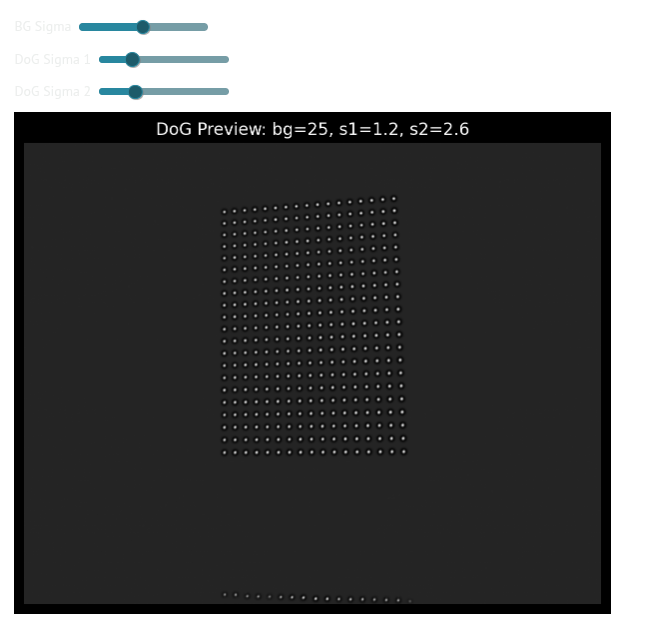

In [ ]:
_dog_preview = preprocess_and_dog(
    img,
    bg_sigma=man_bg.value,
    dog_sigma1=man_s1.value,
    dog_sigma2=man_s2.value,
)

plt.figure(figsize=(8, 6))
plt.imshow(_dog_preview[1200:2000, 500:1500], cmap="gray")
plt.title(
    f"DoG Preview: bg={man_bg.value}, s1={man_s1.value:.1f}, s2={man_s2.value:.1f}"
)
plt.axis("off")
_plot = plt.gca()

mo.vstack([man_bg, man_s1, man_s2, _plot])

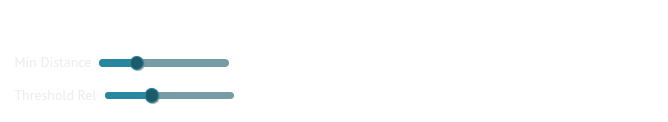

In [ ]:
mo.md("## Step 2: Tune Dot Detection")
man_min_dist = mo.ui.slider(1, 20, value=6, step=1, label="Min Distance")
man_thresh = mo.ui.slider(
    0.01, 0.5, value=0.18, step=0.01, label="Threshold Rel"
)
mo.vstack(
    [
        mo.md("### Step 2: Tune Dot Detection Parameters"),
        man_min_dist,
        man_thresh,
    ]
)

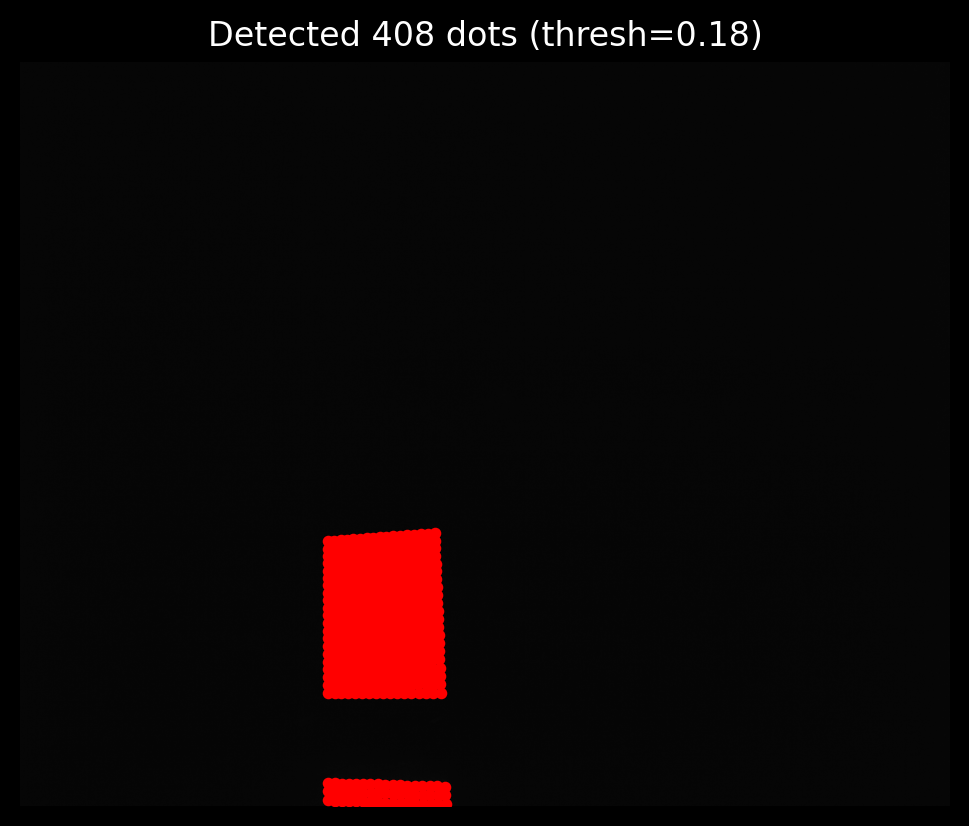

In [ ]:
pts_yx, _ = detect_dots_subpixel(
    img,
    min_distance=man_min_dist.value,
    thresh_rel=man_thresh.value,
    bg_sigma=man_bg.value,
    dog_sigma1=man_s1.value,
    dog_sigma2=man_s2.value,
)

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap="gray")
plt.scatter(pts_yx[:, 1], pts_yx[:, 0], s=10, c="r")
plt.title(f"Detected {len(pts_yx)} dots (thresh={man_thresh.value:.2f})")
plt.axis("off")
plt.gca()

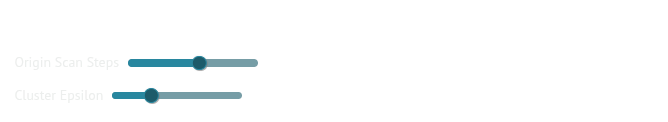

In [ ]:
mo.md("## Step 3: Grid Reconstruction")
man_scan_steps = mo.ui.slider(
    10, 100, value=60, step=10, label="Origin Scan Steps"
)
man_eps = mo.ui.slider(10, 100, value=35, step=1, label="Cluster Epsilon")
mo.vstack(
    [
        mo.md("### Step 3: Grid Reconstruction Parameters"),
        man_scan_steps,
        man_eps,
    ]
)

Grid score: 0, Mapped points: 0/357


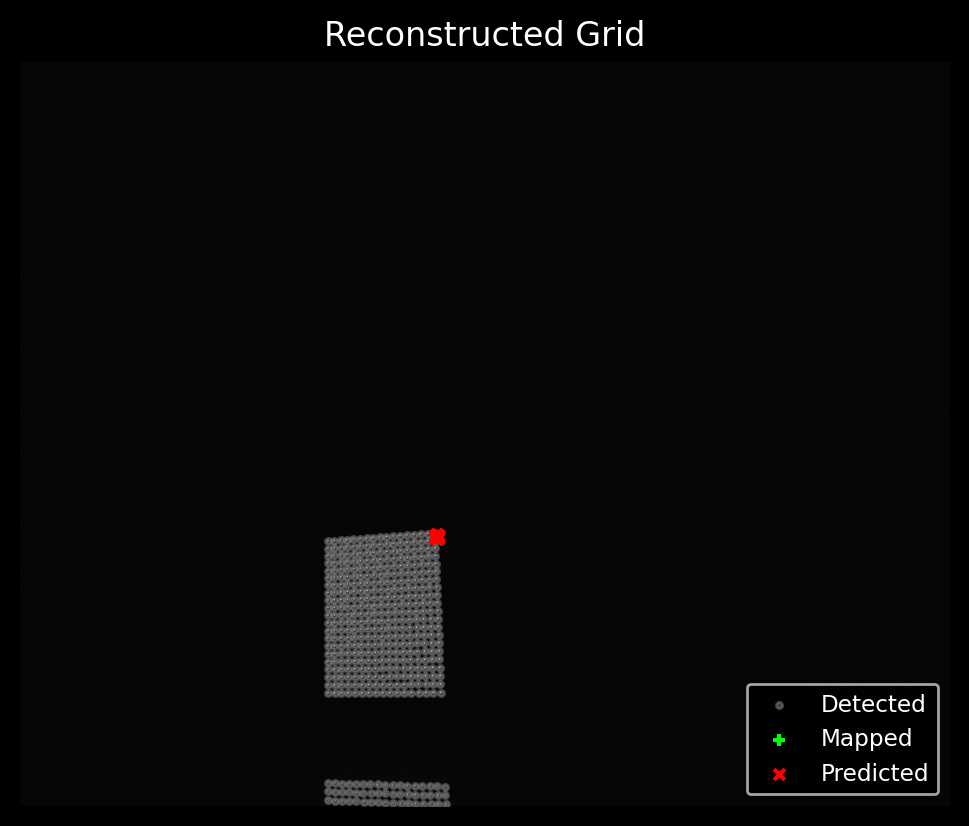

In [ ]:
# Filter points
pts_yx_f = keep_largest_cluster(pts_yx, eps=man_eps.value, min_samples=10)

# Reconstruct
grid_map, pred_yx, _, score = reconstruct_grid_robust(
    pts_yx_f,
    expected_shape=(21, 17),
    origin_scan_steps=man_scan_steps.value,
)

print(f"Grid score: {score}, Mapped points: {len(grid_map)}/{21 * 17}")

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap="gray")
# Plot detected points
plt.scatter(
    pts_yx_f[:, 1], pts_yx_f[:, 0], s=5, c="gray", alpha=0.5, label="Detected"
)
# Plot grid points
found_y, found_x = [], []
pred_y, pred_x = [], []
for r in range(21):
    for c in range(17):
        y, x = pred_yx[r, c]
        if (r, c) in grid_map:
            found_y.append(y)
            found_x.append(x)
        else:
            pred_y.append(y)
            pred_x.append(x)

plt.scatter(found_x, found_y, s=20, c="lime", marker="+", label="Mapped")
plt.scatter(pred_x, pred_y, s=15, c="red", marker="x", label="Predicted")
plt.legend(loc="lower right", fontsize="small")
plt.title("Reconstructed Grid")
plt.axis("off")
plt.gca()

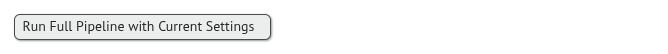

In [ ]:
mo.md("## Step 4: Final Pipeline")
run_all_btn = mo.ui.run_button(label="Run Full Pipeline with Current Settings")
mo.vstack([run_all_btn])

In [ ]:
mo.stop(not run_all_btn.value, mo.md("Click to run full pipeline"))

# Gather parameters
p_bg = man_bg.value
p_s1 = man_s1.value
p_s2 = man_s2.value
p_min_dist = man_min_dist.value
p_thresh = man_thresh.value
p_scan = man_scan_steps.value
p_eps = man_eps.value

# Run
final_grid, final_map, final_pts, _, final_score = find_grid_centroids_robust(
    img,
    nrows=21,
    ncols=17,
    bg_sigma=p_bg,
    dog_sigma1=p_s1,
    dog_sigma2=p_s2,
    min_distance=p_min_dist,
    thresh_rel=p_thresh,
    origin_scan_steps=p_scan,
    cluster_eps=p_eps,
)

print(f"Final Grid Score: {final_score}")
print(f"Final Mapped Points: {len(final_map)}")

plt.figure(figsize=(8, 8))
plt.imshow(img, cmap="gray")
plt.scatter(
    final_grid[:, :, 1], final_grid[:, :, 0], s=20, c="lime", marker="+"
)
plt.title("Final Result")
plt.axis("off")
plt.gca()

<span class="markdown prose dark:prose-invert contents"><span class="paragraph">Click to run full pipeline</span></span>